In [62]:
import pandas as pd, os, requests, sys, numpy as np, datetime
import matplotlib.pyplot as plt
import seaborn as sns
import collections

RECORDING_PATH = os.path.expanduser("~/.talon/recordings")
HOSTNAME = os.uname()[1]
MIN_NUM_SAMPLES = 4
REMOTE_SERVER = "http://localhost:5000"

In [10]:
parseCmd = lambda filename: filename.split("-")[0]

def validForTraining(filename, cmd) -> bool:

    # Send a web request to the server to get the list of commands

    # result= requests.get(REMOTE_SERVER + "/commands")
    # try:
    #     training_commands = result.json()['detail']
    # except Exception as e:
    #     print(" Error getting commands from the server. Is the server running?")
    #     sys.exit(1)
        
    words_in_command = len(cmd.split(" "))
    return filename.endswith(".flac") and \
            words_in_command == 1 and \
            len([f for f in os.listdir(RECORDING_PATH) if parseCmd(f) == cmd]) > MIN_NUM_SAMPLES
            # cmd in training_commands and 

In [18]:
def parse():
    # create training directory if it doesn't exist 

    timesSaid = {}
    dateSaid = {}

    for filename in os.listdir(RECORDING_PATH):

        cmd = parseCmd(filename)

        if validForTraining(filename, cmd):

            timesSaid[cmd] = timesSaid.get(cmd, -1) + 1
        
            file_creation_date = datetime.datetime.fromtimestamp(os.path.getctime(os.path.join(RECORDING_PATH, filename)))
            file_creation_date = file_creation_date.strftime("%m/%d")


            dateSaid[file_creation_date] = dateSaid.get(file_creation_date, -1) + 1
        
    return timesSaid, dateSaid

            
frequencies, dates = parse()

In [82]:
frequencies

{'plex': 7,
 'and': 11,
 'touch': 113,
 'hooks': 61,
 'period': 19,
 'r': 25,
 'fly': 69,
 'equation': 37,
 'space': 415,
 'jury': 18,
 'fine': 23,
 'box': 28,
 'sit': 23,
 'wipe': 70,
 'dot': 212,
 'tab': 66,
 'enter': 435,
 'last': 112,
 'comma': 43,
 'blender': 58,
 'one': 13,
 'equals': 29,
 'cleft': 209,
 'bat': 39,
 'each': 20,
 'made': 5,
 'slash': 13,
 'cap': 17,
 'trap': 6,
 'odd': 9,
 'coma': 33,
 'home': 25,
 'quench': 7,
 'sun': 13,
 'air': 33,
 'near': 14,
 'drum': 4,
 'colgap': 12,
 'yank': 5,
 'vest': 7,
 'whale': 7,
 'round': 9,
 'plus': 8,
 'harp': 6,
 'look': 10,
 'escape': 20,
 'comment': 9,
 'pit': 18,
 'four': 8,
 'red': 13,
 'print': 5,
 'crunch': 15,
 'hash': 5,
 'urge': 4,
 'colon': 8,
 'ten': 10,
 'base': 4}

In [83]:
dates

{'03/04': 274,
 '03/03': 454,
 '03/07': 363,
 '03/02': 160,
 '03/13': 123,
 '03/14': 158,
 '03/06': 187,
 '03/01': 247,
 '03/08': 173,
 '02/27': 93,
 '03/10': 7,
 '03/05': 112,
 '02/28': 191,
 '03/09': 17,
 '03/12': 0}

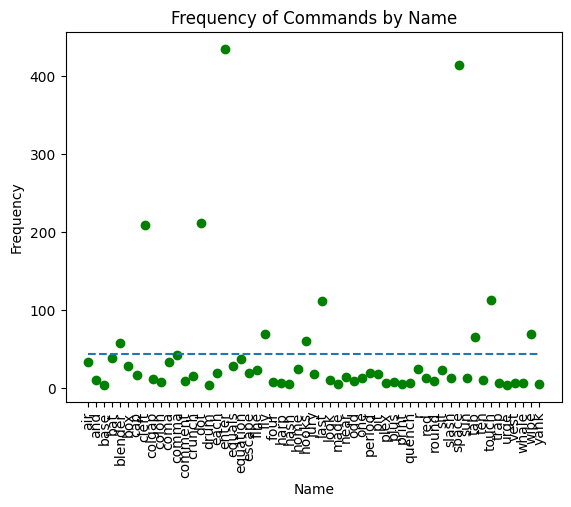

In [80]:
def plot_data_collection(data, metric):
    sorted_dict = dict(sorted(data.items()))
 
    x_values = list(sorted_dict.keys())
    y_values = list(sorted_dict.values())
    #  plot all the data and do a line of best fit
    plt.plot(x_values, y_values, 'o', color='green')
    plt.xticks(rotation=90)
    plt.title(f"Frequency of Commands by {metric}")
    y_mean = [np.mean(y_values)]*len(x_values)

    plt.xlabel(metric)
    plt.ylabel("Frequency")

    # Plot the average line
    mean_line = plt.plot(x_values , y_mean, label='Mean', linestyle='--')

plot_data_collection(frequencies, "Name")

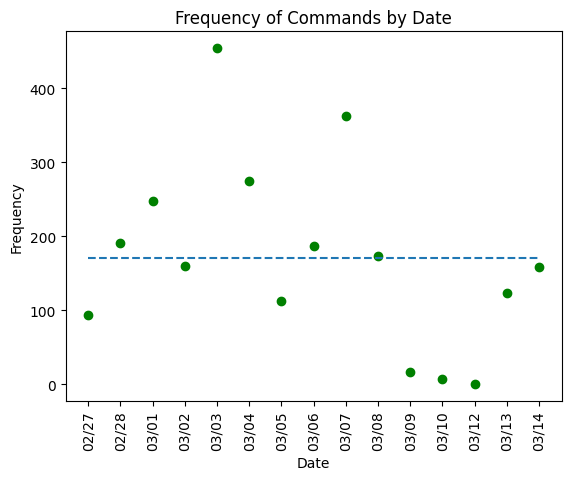

In [81]:
plot_data_collection(dates, "Date")

In [70]:
def summarize(data):
    val = list(data.values())

    return {
        "mean": np.mean(val),
        "median": np.median(val),
        "std": np.std(val),
        "max": np.max(val),
        "min": np.min(val)
    }

print(f'{summarize(frequencies)=}'), 
print(f'{summarize(dates)=}')


summarize(frequencies)={'mean': 44.1578947368421, 'median': 15.0, 'std': 83.84463273026562, 'max': 435, 'min': 4}
summarize(dates)={'mean': 170.6, 'median': 160.0, 'std': 122.74841478949263, 'max': 454, 'min': 0}


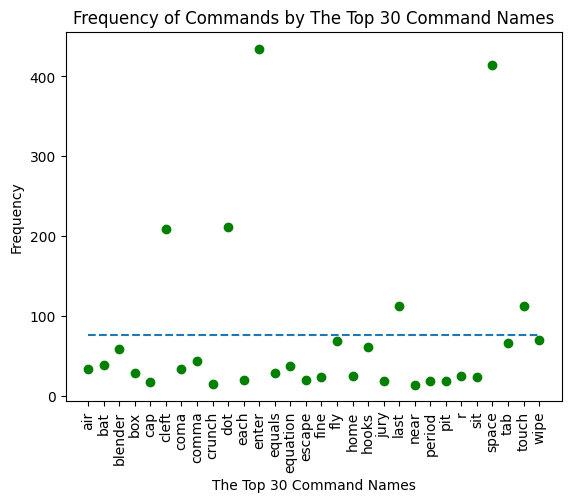

: 

In [93]:
top30 = dict(collections.Counter(frequencies).most_common(30))
top30
plot_data_collection(top30, "The Top 30 Command Names")
